- 주의! 코드 흐름을 보여주기 위해 코드 캡슐화가 잘 되어있지 않습니다. 
- pytorch 모델과 데이터 로더는 클래스로 정의하는게 맞고 나중에 쓰기에도 편리합니다.
- 하지만, 이번에는 무슨 일이 일어나는지 쉽게 보기 위해서 이렇게 작성합니다.

In [134]:
!pip install einops matplotlib

  Using cached matplotlib-3.5.3-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.3 MB)
  Using cached fonttools-4.34.4-py3-none-any.whl (944 kB)
  Using cached Pillow-9.2.0-cp38-cp38-manylinux_2_28_x86_64.whl (3.2 MB)
  Using cached kiwisolver-1.4.4-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.2 MB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)


In [1]:
from transformers import BertForMaskedLM, BertConfig, BertTokenizer
from esm.data import ESMStructuralSplitDataset
import os
import numpy as np
import torch
from einops import rearrange

In [2]:
model = BertForMaskedLM.from_pretrained('./pretrained/', output_attentions=True)
device = 'cpu'
model.to(device)

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [3]:
esm_structural_train = ESMStructuralSplitDataset(
    split_level='superfamily', 
    cv_partition='4', 
    split='train', 
    root_path = os.path.expanduser('~/.cache/torch/data/esm'),
    download=True
)

Files already downloaded and verified


In [4]:
seqs = [data['seq'] for data in esm_structural_train]
contactmap = [data['dist']<8 for data in esm_structural_train]

In [5]:
tokenizer = BertTokenizer.from_pretrained('mytoken')

In [6]:
def generate_batch_contact_map(seqs, contactmap, batch_size, device):
    n = len(seqs)
    nb = n//batch_size
    for i in range(nb):
        inputs = [' '.join(seq) for seq in seqs[i*batch_size:(i+1)*batch_size]]
        inputs = tokenizer(inputs, return_tensors='pt', padding=True)
        inputs['input_ids'].to(device)
        inputs['token_type_ids'].to(device)
        inputs['attention_mask'].to(device)
        ndim = inputs['attention_mask'].shape[1]
        maps = np.zeros((batch_size, ndim, ndim, 1))
        for j, c in enumerate(contactmap[i*batch_size:(i+1)*batch_size]):
            cdim = c.shape[0]
            maps[j, 1:cdim+1, 1:cdim+1, 0] = c
        maps = torch.FloatTensor(maps)
        maps.to(device)
        yield inputs, maps
  

In [7]:
from transformers import AdamW
optim = AdamW(model.parameters(), lr = 1e-5)
contact_map_layer = torch.nn.Linear(144, 1)
activation = torch.nn.Sigmoid()


/home/jackjack5/program/anaconda3/envs/contact_prediction/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [16]:
epochs = 10
batch_size = 10
for epoch in range(epochs):
    gen = generate_batch_contact_map(seqs, contactmap, batch_size, device)
    for inputs, maps in gen:
        optim.zero_grad()
        out = model(**inputs)
        attn = torch.concat(out['attentions'], axis=1)
        attn = rearrange(attn, 'b n s t -> b s t n')
        contact_pred_output = activation(contact_map_layer(attn))
        
        mask = rearrange(inputs['attention_mask'], 'b n  -> b n 1 1') * rearrange(inputs['attention_mask'], 'b n  -> b 1 n 1')
        y_pred = contact_pred_output[mask>0]
        y = maps[mask>0]

        p = sum(y)/y.shape[0]
        w1 = 1/p
        w2 = 1/(1-p)
        weight = (w1 - w2) * y + w2
        lossfn = torch.nn.BCELoss(weight=weight)
        
        loss = lossfn(y_pred, y)
        loss.backward()
        optim.step()
        print('loss : ',loss.item())
        

loss :  1.3867311477661133
loss :  1.3868674039840698
loss :  1.3869740962982178
loss :  1.386949896812439
loss :  1.3867762088775635
loss :  1.38692045211792
loss :  1.3870742321014404
loss :  1.3869534730911255
loss :  1.3870395421981812


KeyboardInterrupt: 

In [17]:
def get_contact_prediction(model, seq, tokenizer):
    inputs = ' '.join(seq)
    inputs = tokenizer(inputs, return_tensors='pt', padding=True)
    inputs['input_ids'].to(device)
    inputs['token_type_ids'].to(device)
    inputs['attention_mask'].to(device)
    out = model(**inputs)
    attn = torch.concat(out['attentions'], axis=1)
    attn = rearrange(attn, 'b n s t -> b s t n')
    contact_pred_output = activation(contact_map_layer(attn))
    contact_pred_output = contact_pred_output[0, 1:-1, 1:-1, 0].detach().numpy()
    return contact_pred_output

In [18]:
seq = seqs[0]
output = get_contact_prediction(model, seq, tokenizer)

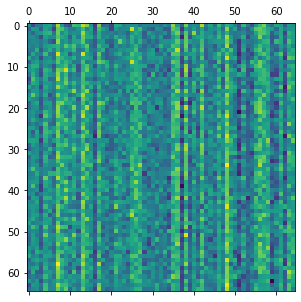

In [19]:
import matplotlib.pyplot as plt
plt.matshow(output)

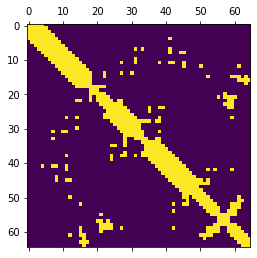

In [20]:
plt.matshow(contactmap[0])